# Разработка системы предупреждения аварий на каршеринге

**Цель** - Исследовать данные каршеринговой компании.

**Задача** - Построить систему предупреждения о ДТП по выбранному маршруту движения. И понять возможно ли вообще создание такой системы для оценки риска при выдаче авто.

**Описание таблиц**

- `collisions` — общая информация о ДТП. Например, где оно произошло и когда. Имеет уникальный case_id.
- `parties` — информация об участниках ДТП. Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.
- `vehicles` — информация о пострадавших машинах. Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

**План исследования**
1. Изучение данных
2. Статистический анализ факторов ДТП
3. Подготовка набора данных
4. Обучение моделей
5. Проверка лучшей модели в работе
6. Анализ важности факторов ДТП
7. Общий вывод

## Изучить данные
### Библиотеки

In [5]:
import warnings
import datetime

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from scipy.stats import shapiro
import statsmodels.api as sm

from sqlalchemy import (
    create_engine, MetaData, Table, inspect)
from sqlalchemy.orm import sessionmaker

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_auc_score
from sklearn.exceptions import FitFailedWarning

import phik
from phik.report import plot_correlation_matrix

from lightgbm import LGBMClassifier

In [6]:
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

warnings.simplefilter('ignore',  UserWarning)
warnings.simplefilter('ignore',  FitFailedWarning)
warnings.simplefilter('ignore',  FutureWarning)

### Функции

In [7]:
def test_shapiro(data, alpha):
    '''
    Функция проверяет данные на нормальное
    распределени, используя тест Шапиро-Уилка и
    строит график QQ-plot. Принимает столбец и 
    сверяет его p-value с уровнем статистической 
    значимости, выводит ответ о нормальности и график.
    '''

    stat, p = shapiro(data)

    if p > alpha:
        print('Не отвергаем H0. Данные получены из нормального распределения')
    else:
        print('Отвергаем H0 и принимаем H1.\
Данные получены из ненормального распределения')

    sm.qqplot(data, line='s')
    plt.title(f'QQ-plot {data.name}')

### Константы

In [8]:
ALPHA = 0.05
RANDOM_STATE = 42
TEST_SIZE = 0.25

### Загрузка таблиц sql

Для загрузки данных необходимо сначала подключиться к базе данных

In [9]:
# Данные для подключения к базе данных
db_config = {
    'user': 'praktikum_student',
    'pwd': 'Sdf4$2;d-d30pp',
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,
    'db': 'data-science-vehicle-db'
}

In [10]:
# Создаем строку для соедиенния с базой данных
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Теперь можно подключаться к базе данных

In [11]:
# Подключаемся к базе данных
engine = create_engine(connection_string)

Теперь можно работать с базой данных. Для начала выясним, соответствует ли количество таблиц условию задачи.

In [12]:
metadata = MetaData()  # Создаем объект

In [13]:
# Загружаем метаданные из базы данных и выводим названия всех таблиц
metadata.reflect(bind=engine)

for table in metadata.tables:
    print(table)

collisions
case_ids
parties
vehicles


По условию задачи у нас должно быть всего 4 таблицы, что в результате мы и получаем.

Теперь узнаем все ли таблицы имеют набор данных. Для этого необходимо создать сессию.

In [14]:
Session = sessionmaker(bind=engine)  # Объявляем сессию

In [15]:
session = Session()  # Создаем объект

In [16]:
# Создаем цикл для подсчета записей во всех таблицах
for table_name, table in metadata.tables.items():
    count = session.query(table).count()
    if count == 0:
        print(f'Таблица {table_name} не содержит набор данных.')
    else:
        print(f'Таблица {table_name} содержит {count} записей.')

Таблица collisions содержит 1400000 записей.
Таблица case_ids содержит 1400000 записей.
Таблица parties содержит 2752408 записей.
Таблица vehicles содержит 1021234 записей.


In [17]:
session.close()  # Закрываем сессию

Посмотрим имеется ли общий ключ для связи таблиц. Судя по документации к БД общим ключом должен быть `case_id` поэтому если этот столбец присутствует во всех таблицах, значит общий ключ есть. Надо это проверить. Также заодно проверим типы данных у каждого столбца

In [18]:
# Пишем sql-запрос для вывода названия столбцов и типов данных
query = '''
SELECT column_name,
       data_type
FROM information_schema.columns
WHERE table_name = 'collisions'
ORDER BY column_name
'''

In [19]:
pd.read_sql_query(query, con=engine)

,column_name,data_type
0,case_id,text
1,collision_damage,text
2,collision_date,date
3,collision_time,time without time zone
4,control_device,text
5,county_city_location,text
6,county_location,text
7,direction,text
8,distance,real
9,intersection,integer


Столбец `case_id` есть. Изучим оставшиеся таблицы

In [20]:
# Пишем sql-запрос для вывода названия столбцов и типов данных
query = '''
SELECT column_name,
       data_type
FROM information_schema.columns
WHERE table_name = 'parties'
ORDER BY column_name
'''

In [21]:
pd.read_sql_query(query, con=engine)

,column_name,data_type
0,at_fault,integer
1,case_id,text
2,cellphone_in_use,integer
3,id,integer
4,insurance_premium,integer
5,party_drug_physical,text
6,party_number,integer
7,party_sobriety,text
8,party_type,text


Столбец `case_id` также есть.

In [22]:
# Пишем sql-запрос для вывода названия столбцов и типов данных
query = '''
SELECT column_name,
       data_type
FROM information_schema.columns
WHERE table_name = 'vehicles'
ORDER BY column_name
'''

In [23]:
pd.read_sql_query(query, con=engine)

,column_name,data_type
0,case_id,text
1,id,integer
2,party_number,integer
3,vehicle_age,integer
4,vehicle_transmission,text
5,vehicle_type,text


И здесь он есть 

In [24]:
# Пишем sql-запрос для вывода названия столбцов и типов данных
query = '''
SELECT column_name,
       data_type
FROM information_schema.columns
WHERE table_name = 'case_ids'
ORDER BY column_name
'''

In [25]:
pd.read_sql_query(query, con=engine)

,column_name,data_type
0,case_id,text
1,db_year,text


Во всех таблицах есть общий ключ для связи таблиц. Таблица `vehicles` имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей `collisions` и таблицей `parties`.

### Вывод

В этом разделе провели первичное исследование имеющихся таблиц в БД.

Узнали, что количество таблиц совпадает с таблицами, которые указаны в документации к БД:
- `collisions`
- `case_ids`
- `parties`
- `vehicles`

Далее проверили все ли таблицы имеют набор данных. В результате получили, что во всех таблицах есть данные

- Таблица `collisions` содержит 1400000 записей.
- Таблица `case_ids` содержит 1400000 записей.
- Таблица `parties` содержит 2752408 записей.
- Таблица `vehicles` содержит 1021234 записей.

Последним действием была проверка на наличие общего ключа для связи таблиц. По итогу во всех таблицах есть общий ключ для связи `case_id`.

##  Cтатистический анализ факторов ДТП

Заказчик хочет узнать, в какие месяцы происходит наибольшее количество аварий. Для этого необходимо сгруппировать данные по месяцам и посчитать количество аварий. Создадим для этого sql-запрос и построим график.

In [26]:
# Пишем sql-запрос
query = '''
SELECT EXTRACT(YEAR FROM c.COLLISION_DATE) AS year,
       EXTRACT(MONTH FROM c.COLLISION_DATE) AS month,
       COUNT(c.CASE_ID)
FROM collisions AS c
GROUP BY EXTRACT(YEAR FROM c.COLLISION_DATE), EXTRACT(MONTH FROM c.COLLISION_DATE)
'''

In [27]:
# Записываем результат запроса в датафрейм и сортируем по количеству аварий
month_collisions = pd.read_sql_query(
    query, con=engine).sort_values(by='count', ascending=False)

Посмотрим за какие года у нас данные полные и по ним построим график

In [29]:
month_collisions['year'].value_counts()

2011.0    12
2010.0    12
2009.0    12
2012.0    12
2013.0     6
2020.0     2
Name: year, dtype: int64

Данные за каждый месяц есть только за 4 года.

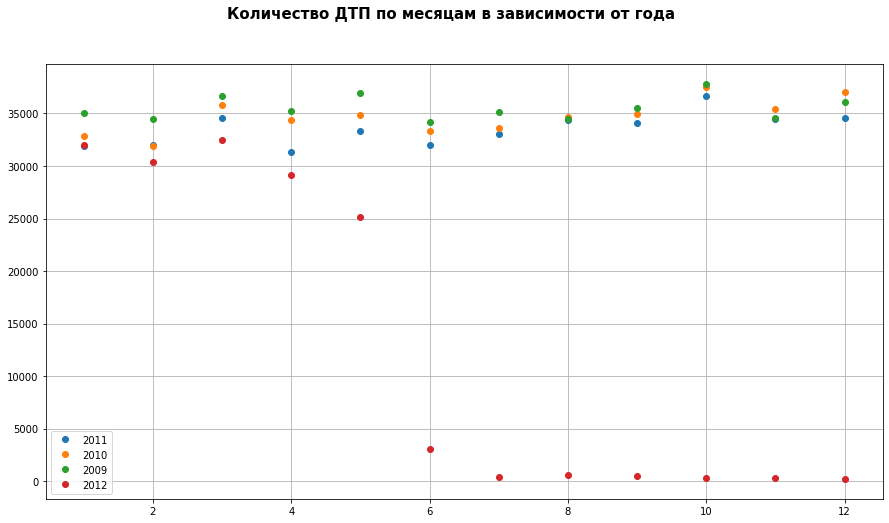

In [30]:
# Строим график
fig, axes = plt.subplots(1, 1, figsize=(15, 8))

plt.suptitle('Количество ДТП по месяцам в зависимости от года',
             fontsize=15, fontweight='bold')

axes.plot(month_collisions[month_collisions['year'] == 2011.0]['month'],
          month_collisions[month_collisions['year'] == 2011.0]['count'],
          month_collisions[month_collisions['year'] == 2010.0]['month'],
          month_collisions[month_collisions['year'] == 2010.0]['count'],
          month_collisions[month_collisions['year'] == 2009.0]['month'],
          month_collisions[month_collisions['year'] == 2009.0]['count'],
          month_collisions[month_collisions['year'] == 2012.0]['month'],
          month_collisions[month_collisions['year'] == 2012.0]['count'], marker='o', linestyle='None')
axes.legend(['2011', '2010', '2009', '2012'])
axes.grid()

Можно отметить, что данные за все года до мая месяца одинаковые по количеству ДТП. После мая в 2012 году данных о ДТП стало резко меньше.
Чаще всего аварии происходят в марте в независимости от года. Топ-5 месяцев по авариям следующий:
- Март
- Январь
- Май
- Апрель
- Февраль

Как можно заметить, все месяцы включает первую половину года. Можно предположить, что это связано с погодными условиями и человеческим фактором, так, например, в январе и феврале обычно это самые холодные месяцы и выпадает большое количество снега. Весенние месяцы по той причине, что весной погода очень переменчива, в марте может быть как тепло, так и происходить заморозки из-за чего на улицах будет гололедица. То же самое можно сказать и про апрель и даже про май(в некоторой части может еще лежать снег). В таких погодных условиях люди чаще ошибаются. 

Также есть еще ряд возможных факторов, такие как:

- Компания может не успевать своевременно менять шины с летней на зимнею и наоборот.
- С наступлением весны, значительно возрастает скорость движения, что ведет к увеличению числа ДТП.
- Весной больше не опытных водителей, которые по-разным причинам отказываются ездить зимой и поэтому возрастает вероятность ДТП с участием не опытных водителей.

Также заказчик потребовал, чтобы на совещание рабочей группы обсуждение было конструктивным и каждый сотрудник должен понимать данные. Для этого необходимо создать аналитические задачи (не менее 6).

1. Какие автомобиле чаще попадают в ДТП. (таблица vehicles)
2. Провести анализ попадания в ДТП в зависимости от наличия телефона в автомобиле (таблица parties)
3. Провести анализ состояния участника ДТП (трезвость / cостояние участника: физическое или с учётом принятых лекарств), исходя из времени года (связать collisions и parties)
4. Есть ли зависимость ДТП между местом происшествия и типом КПП (связать collisions и vehicles)
5. Какая частая категория нарушения ДТП (таблица collisions)
6. Провести анализ возникновения ДТП на разных дорогах, исходя из типа участника происшествия и погоды (связать collisions и parties)
7. Найти количество аварий в зависимости от погоды и ручной кробки передач (связать collisions и vehicles)
8. Происходят ли чаще ДТП летом в ночное время суток. (таблица collisions)

Пропишем порядок решения для двух задач из списка. Возьмем задачу 3.

- Необходимо создать sql-запрос. Объединить две таблицы. Сделать группировку по двум категориям. Посчитать количество ДТП в каждой из них и вывести.
- Построить график зависимости, есть вероятность, что представить все на одном графике не получиться. Распределите графики, чтобы было удобно на них смотреть.
- Сделать вывод по полученным результатам.

Согласно документации к БД у нас есть значения `None` при создании sql-запроса мы учтем это.

In [31]:
# Пишем sql-запрос
query = '''
SELECT c.WEATHER_1 AS weather,
       p.PARTY_SOBRIETY AS participant_sobriety,
       COUNT(c.case_id)
FROM parties AS p
INNER JOIN collisions AS c ON p.case_id = c.case_id
WHERE p.PARTY_SOBRIETY IS NOT NULL
  AND c.WEATHER_1 IS NOT NULL
GROUP BY c.WEATHER_1, p.PARTY_SOBRIETY
'''

In [32]:
# Записываем результат запроса в датафрейм
weather_sobriety = pd.read_sql_query(query, con=engine)

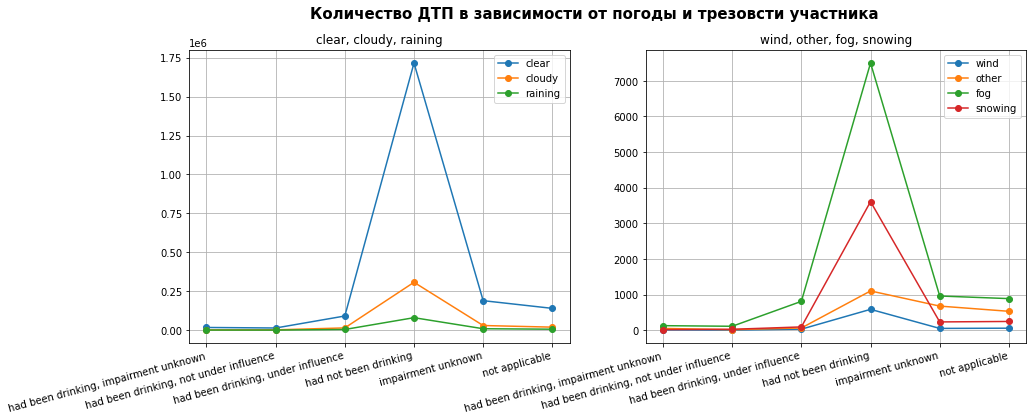

In [33]:
# Строим графики
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

plt.suptitle('Количество ДТП в зависимости от погоды и трезовсти участника',
             fontsize=15, fontweight='bold')

# Выделяем отдельно эти 3 группы, так как у них по сравнению с другими
# намного больше ДТП
axes[0].plot(weather_sobriety[weather_sobriety['weather'] == 'clear']['participant_sobriety'],
             weather_sobriety[weather_sobriety['weather'] == 'clear']['count'],
             weather_sobriety[weather_sobriety['weather']
                              == 'cloudy']['participant_sobriety'],
             weather_sobriety[weather_sobriety['weather']
                              == 'cloudy']['count'],
             weather_sobriety[weather_sobriety['weather']
                              == 'raining']['participant_sobriety'],
             weather_sobriety[weather_sobriety['weather'] == 'raining']['count'], marker='o')
axes[0].set_title("clear, cloudy, raining")
axes[0].legend(['clear', 'cloudy', 'raining'])
axes[0].grid()

# Второй график для остальной погоды
axes[1].plot(weather_sobriety[weather_sobriety['weather'] == 'wind']['participant_sobriety'],
             weather_sobriety[weather_sobriety['weather'] == 'wind']['count'],
             weather_sobriety[weather_sobriety['weather']
                              == 'other']['participant_sobriety'],
             weather_sobriety[weather_sobriety['weather'] == 'other']['count'],
             weather_sobriety[weather_sobriety['weather']
                              == 'fog']['participant_sobriety'],
             weather_sobriety[weather_sobriety['weather'] == 'fog']['count'],
             weather_sobriety[weather_sobriety['weather']
                              == 'snowing']['participant_sobriety'],
             weather_sobriety[weather_sobriety['weather'] == 'snowing']['count'], marker='o')
axes[1].set_title("wind, other, fog, snowing")
axes[1].legend(['wind', 'other', 'fog', 'snowing'])
axes[1].grid()
fig.autofmt_xdate(rotation=15)

Как можно увидеть большинство ДТП происходило, когда участник не пил в независимости от погоды. Больше всего ДТП в ясную погоду, что также подтверждает вывод из прошлой задачи, что с наступлением весны появляются больше не опытных водителей.

Меньше всего аварий в ветреную погоду, возможно, это связно с тем, что в ветреную погоду сложнее управлять автомобилем и люди больше сконцентрированы на дороге, либо вообще стараются не садиться за руль.

Теперь возьмем задачу 4. Данная задача предполагает, что, возможно, на перекрестках, машины на ручной коробке передач чаще попадают в столкновения. Из-за человеческого фактора (не успевают во время среагировать и переключить передачи).

- Необходимо создать sql-запрос. Объединить две таблицы. Сделать группировку по двум категориям. Посчитать количество ДТП в каждой из них и вывести.
- Построить barplot по типу КПП
- Сделать вывод по полученным результатам.

Согласно документации к БД у нас есть значения `None` при создании sql-запроса надо это учесть.

In [34]:
# Пишем sql-запрос
query = '''
SELECT c.INTERSECTION,
       v.VEHICLE_TRANSMISSION,
       COUNT(c.case_id)
FROM collisions AS c
INNER JOIN vehicles AS v ON c.case_id = v.case_id
WHERE c.INTERSECTION IS NOT NULL
GROUP BY c.INTERSECTION, v.VEHICLE_TRANSMISSION
'''

In [35]:
# Записываем результат запроса в датафрейм
inter_trans = pd.read_sql_query(query, con=engine)

In [36]:
# Заменяем пустые значения в типе КПП на другие
inter_trans = inter_trans.fillna('other')

In [37]:
# Заменяем на более понятное обозначения
inter_trans['intersection'] = inter_trans['intersection'].replace(
    {0: 'Перекресток', 1: 'Не перекресток'})

In [38]:
inter_trans  # Выводим результат

,intersection,vehicle_transmission,count
0,Перекресток,auto,361120
1,Перекресток,manual,366174
2,Перекресток,other,13991
3,Не перекресток,auto,138418
4,Не перекресток,manual,126277
5,Не перекресток,other,9207


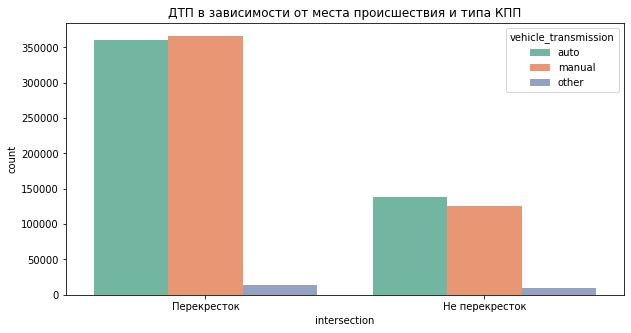

In [39]:
# Строим график
plt.figure(figsize=(10, 5))
sns.barplot(x='intersection', y='count', hue='vehicle_transmission',
            data=inter_trans, palette=sns.color_palette('Set2'))
plt.title('ДТП в зависимости от места происшествия и типа КПП')

Изначальная догадка, что машины с ручной КПП чаще попадают в ДТП на перекрестках не подтвердилась. Но можно отметить, что ДТП на перекрестке значительно превышает ДТП на не перекрестках. Здесь, как и предполагалось, играет человеческий фактор и люди не успевают во время среагировать на ситуацию на дороге.

### Вывод

В данном разделе провели анализ факторов ДТП. 

По требованию заказчика нашли в какие месяцы происходит наибольшее количество аварий. Сначала отобрали за какие года у нас данные по всем месяцам, выяснили, что данные такие есть только за 4 года. Отметили, что после мая в 2012 году, данных о ДТП стало резко меньше.Топ-5 месяцев по авариям в независимости от года следующий:

- Март
- Январь
- Май
- Апрель
- Февраль

И сделали выводы по какой причине именно эти месяцы в топе. Кратко, влияние погоды и появления большего количества неопытных водителей весной.

Также заказчик потребовал, создать аналитические задачи, чтобы лучше разбираться в данных. По итогу было написано 8 задач и две из них были подробно расписаны и реализованы.

## Подготовка набора данных

Подготовим набор данных на основе первичного предположения заказчика:
 
- Тип виновника — только машина (car). 
- Случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH.
- Данные только за 2012 год.

Напишем для этого sql-запрос

In [40]:
# Пишем sql-запрос
query = '''
SELECT *
FROM parties AS p
INNER JOIN collisions AS c ON p.case_id = c.case_id
INNER JOIN vehicles AS v ON c.case_id = v.case_id AND v.party_number = p.party_number
WHERE p.PARTY_TYPE = 'car'
  AND c.COLLISION_DAMAGE != 'scratch'
  AND EXTRACT(YEAR FROM c.COLLISION_DATE) = '2012'
'''

In [41]:
# Записываем результат запроса в датафрейм
total_df = pd.read_sql_query(query, con=engine)

Посотрим на результат и выведим первые 5 строк датафрейма.

In [42]:
total_df.head()  # Выводим первые 5 строк

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,2657345,5599684,2,car,0,46.0,had not been drinking,None,0.0,5599684,1942,los angeles,20.0,south,0.0,clear,None,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,daylight,functioning,2012-04-15,17:05:00,1463713,5599684,2,sedan,auto,2.0
1,2395824,5449062,2,car,0,54.0,had not been drinking,None,0.0,5449062,0708,contra costa,21.0,east,0.0,clear,None,small damage,2,vehicle code violation,dui,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2012-01-15,02:00:00,1320506,5449062,2,sedan,manual,10.0
2,2680477,5612888,1,car,1,28.0,had not been drinking,None,0.0,5612888,3026,orange,40.0,north,0.0,clear,None,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,functioning,2012-05-04,12:50:00,1475782,5612888,1,sedan,auto,4.0
3,2680781,5613058,1,car,1,45.0,had not been drinking,None,0.0,5613058,1900,los angeles,0.0,None,1.0,clear,None,small damage,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2012-05-07,13:04:00,1475866,5613058,1,sedan,auto,0.0
4,2681864,5613642,2,car,0,20.0,had not been drinking,None,0.0,5613642,0109,alameda,1900.0,west,0.0,clear,highway,small damage,4,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,dark with street lights,none,2012-03-25,19:50:00,1476685,5613642,2,sedan,auto,0.0


Теперь проведем первичный отбор факторов, необходимых для модели. То есть нужно взять те признаки, которые могут влиять на вероятность ДТП.

Возьмем следующие признаки:
- `at_fault` - целевой признак
- `party_sobriety` - очень важный признак, так как в зависимости от состояния участника может повышаться вероятность ДТП
- `party_drug_physical` - аналогично предыдущему признаку. Только уже с учетом физического состояния участника.
- `cellphone_in_use` - наличие телефона также может влиять на вероятность ДТП, так как водитель менее сконцентрирован на дороге.
- `weather_1` - погода также влияет на вероятность ДТП. В зависимости какая погода, концентрация водителя должна меняться, а также его скорость передвижения.
- `location_type` - тоже может влиять на вероятность ДТП. Так как на разных типах дорог, разная скорость передвижения. 
- `road_surface` - состояние дороги влияет на вероятность ДТП. Чем не стандартнее оно, тем сложнее ездить и нужна большая концентрация и опыт. (Возможно, будет сильная корреляция с погодой, так как от погоды зависит состояние дороги)
- `lighting` - освещения важная составляющая. Так как чем хуже оно, тем меньше водитель видит дорогу.
- `county_city_location` - обычно в городах есть места, в которых ДТП происходят чаще обычного.
- `pcf_violation_category` - обычно нарушение ПДД влечет за собой ДТП.
- `collision_time` - время суток также важно. В ночное время ездить опаснее. (Возможно, будет сильная корреляция с освещением)
- `road_condition_1` - чем хуже дорожное покрытие, тем сложнее водителю.
- `vehicle_age` -  условия заказчика

In [43]:
# Создаем список отобранных признаков
columns = ['at_fault', 'party_sobriety', 'party_drug_physical', 'cellphone_in_use', 'weather_1',
           'location_type', 'road_surface', 'lighting', 'county_city_location',
           'pcf_violation_category', 'collision_time', 'road_condition_1', 'vehicle_age']

In [44]:
# Создаем датафрейм с отобранными признаками
selected_df = total_df[columns]
selected_df.shape

(56248, 13)

Посмотрим на первые 5 строк

In [45]:
selected_df.head()

,at_fault,party_sobriety,party_drug_physical,cellphone_in_use,weather_1,location_type,road_surface,lighting,county_city_location,pcf_violation_category,collision_time,road_condition_1,vehicle_age
0,0,had not been drinking,None,0.0,clear,None,dry,daylight,1942,unsafe lane change,17:05:00,normal,2.0
1,0,had not been drinking,None,0.0,clear,None,dry,dark with street lights,0708,dui,02:00:00,normal,10.0
2,1,had not been drinking,None,0.0,clear,None,dry,daylight,3026,speeding,12:50:00,normal,4.0
3,1,had not been drinking,None,0.0,clear,None,dry,daylight,1900,automobile right of way,13:04:00,normal,0.0
4,0,had not been drinking,None,0.0,clear,highway,dry,dark with street lights,0109,unsafe lane change,19:50:00,normal,0.0


Посмотрми информацию о нашем датафрейме.

In [46]:
selected_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   at_fault                56248 non-null  int64  
 1   party_sobriety          55376 non-null  object 
 2   party_drug_physical     2857 non-null   object 
 3   cellphone_in_use        51777 non-null  float64
 4   weather_1               56080 non-null  object 
 5   location_type           25932 non-null  object 
 6   road_surface            55900 non-null  object 
 7   lighting                56094 non-null  object 
 8   county_city_location    56248 non-null  object 
 9   pcf_violation_category  55482 non-null  object 
 10  collision_time          56160 non-null  object 
 11  road_condition_1        55999 non-null  object 
 12  vehicle_age             54554 non-null  float64
dtypes: float64(2), int64(1), object(10)
memory usage: 5.6+ MB


В таблице 13 столбцов - `float`(2), `int`(1) и `object`(10). Количество значений в столбцах разное (в документации к БД во многих категория была категория `None`, их следует заменить на какую-нибудь заглушку). 

Следует также поменять тип данных в некоторых столбцах (`collision_time`, `county_city_location`, `cellphone_in_use`, `at_fault` и `vehicle_age`). Стоит также сделать проверку на явные и неявные дубликаты. 

После этого провести исследовательский и корреляционный анализ получившегося датафрейма.

#### Работа с пропусками

Посмотрим сколько пропусков в каждом столбце и их долю от общего числа.

In [47]:
# Ищем количество пропусков
count_na = pd.Series(selected_df.isna().sum(), name='Пропуски')

In [48]:
# Находим долю пропусков
poroportion_na = pd.Series(
    round((selected_df.isna().sum() / len(selected_df)) * 100, 2), name='Доля')

In [49]:
# Обьединяем в таблицу
pd.concat([count_na, poroportion_na], axis=1)

,Пропуски,Доля
at_fault,0,0.00
party_sobriety,872,1.55
party_drug_physical,53391,94.92
cellphone_in_use,4471,7.95
weather_1,168,0.30
location_type,30316,53.90
road_surface,348,0.62
lighting,154,0.27
county_city_location,0,0.00
pcf_violation_category,766,1.36


В некоторых столбцах пропусков вообще нет. В каких-то очень много и составляют большую часть.

Заполним пропуски в данных. Пропущенные значения в столбце `cellphone_in_use` заменим 0, так как в документации не сказано, что могут быть пропущенные значения, то предполагаем, что пустое значение это 0 и телефона не было. Пропуски в столбце `vehicle_age` заполним медианным значением, так как у нас заказчик каршеринговая компания, то они обычно закупаются автомобили оптом, а значит возраст должен быть +- у всех одинаковый. Все остальные пропуски будут заполнены заглушкой `unknown`.

Пропуски в столбце `collision_time` заполнять заглушкой не будем и удалим их.

In [50]:
# Удаляем пропуски в collision_time
selected_df = selected_df.dropna(
    subset=['collision_time']).reset_index(drop=True)

In [51]:
# Заменяем пропуски в cellphone_in_use на 0
selected_df['cellphone_in_use'] = selected_df['cellphone_in_use'].fillna(0)

In [52]:
# Заполняем пропуски медианным значеним
selected_df['vehicle_age'] = selected_df['vehicle_age'].fillna(
    selected_df['vehicle_age'].median())

In [53]:
# Создаем список столбцов для замены пропусков заглушкой
columns_unknown = ['party_sobriety', 'party_drug_physical', 'weather_1', 'location_type',
                   'road_surface', 'lighting', 'pcf_violation_category', 'road_condition_1']

In [54]:
# В цикле заменяем пропуски заглушкой unknown
for column in columns_unknown:
    selected_df[column] = selected_df[column].fillna('unknown')

Следует поменять тип данных у `collision_time`, `county_city_location` и `cellphone_in_use`. А также у `at_fault` для экономичного управления памятью.

#### Изменение типов данных

In [55]:
# Меняем тип данных
selected_df['collision_time'] = pd.to_datetime(
    selected_df['collision_time'], format='%H:%M:%S').dt.time
selected_df['at_fault'] = selected_df['at_fault'].astype('int8')
selected_df['cellphone_in_use'] = selected_df['cellphone_in_use'].astype(
    'int8')
selected_df['county_city_location'] = selected_df['county_city_location'].astype(
    'int32')
selected_df['vehicle_age'] = selected_df['vehicle_age'].astype('int16')

#### Работа с явными дубликатами

Посмотрим есть дубликаты в датафрейме

In [56]:
# Считаеем дубликаты
selected_df.duplicated().sum()

662

К сожалению, дубликаты есть. Необходимо от них избавиться.

In [57]:
# Удаляем дубликаты
selected_df = selected_df.drop_duplicates().reset_index(drop=True)

#### Работа с неявными дубликатами.

Так как у нас очень много категориальных признаков, необходимо их проверить на наличие неявных дубликатов, так как одни и те же значения могут быть написаны по-разному.

In [58]:
# Считаем количество значений
selected_df['party_sobriety'].value_counts()

had not been drinking                     47908
had been drinking, under influence         4419
impairment unknown                         1224
unknown                                     868
had been drinking, not under influence      573
had been drinking, impairment unknown       256
not applicable                              250
Name: party_sobriety, dtype: int64

In [59]:
# Считаем количество значений
selected_df['party_drug_physical'].value_counts()

unknown                  52672
G                         1224
under drug influence       841
sleepy/fatigued            390
not applicable             250
impairment - physical      121
Name: party_drug_physical, dtype: int64

In [60]:
# Считаем количество значений
selected_df['weather_1'].value_counts()

clear      44423
cloudy      8365
raining     2166
fog          179
unknown      167
snowing      154
other         33
wind          11
Name: weather_1, dtype: int64

In [61]:
# Считаем количество значений
selected_df['location_type'].value_counts()

unknown         29907
highway         21015
ramp             3240
intersection     1336
Name: location_type, dtype: int64

In [62]:
# Считаем количество значений
selected_df['road_surface'].value_counts()

dry         49541
wet          5221
snowy         353
unknown       340
slippery       43
Name: road_surface, dtype: int64

In [63]:
# Считаем количество значений
selected_df['lighting'].value_counts()

daylight                                   37534
dark with street lights                    10889
dark with no street lights                  5041
dusk or dawn                                1750
unknown                                      150
dark with street lights not functioning      134
Name: lighting, dtype: int64

In [64]:
# Считаем количество значений
selected_df['pcf_violation_category'].value_counts()

speeding                             17909
improper turning                      8128
automobile right of way               7025
dui                                   6137
unsafe lane change                    4625
traffic signals and signs             3341
unknown                               1646
unsafe starting or backing            1372
wrong side of road                    1362
other than driver (or pedestrian)     1143
following too closely                 1006
other hazardous violation              514
improper passing                       477
pedestrian violation                   313
other improper driving                 223
pedestrian right of way                112
other equipment                         84
impeding traffic                        33
hazardous parking                       32
brakes                                  10
lights                                   3
fell asleep                              3
Name: pcf_violation_category, dtype: int64

In [65]:
# Считаем количество значений
selected_df['road_condition_1'].value_counts()

normal            53339
construction        991
obstruction         247
unknown             246
other               226
holes               219
loose material      127
reduced width        71
flooded              32
Name: road_condition_1, dtype: int64

Неявные дубликаты не обнаружены.

Перед исследовательским анализом сделаем выводы о проделанной работе.

Сформировали датафрейм на основе первичного предположения заказчика. Из этого датафрейма выделили основные признаки, которые могут повлиять на ДТП. Этот выбор мы обосновали. По итогу у нас получилась таблица размером (56248, 13).

Далее продолжили работу с этим датафреймом. 

- Заполнили пропуски в столбце `cellphone_in_use` нулями, так как скорее всего, наличие пропусков связано с тем, что телефона нет. Пропуски в столбце `vehicle_age` заполнили медианным значением, так как предположили, что раз это каршеринговая компания, то она закупает машины оптом, а следовательно, возраст у них должен быть одинаковым. Пропуски в столбце `collision_time` заполнять заглушкой не будем и удалим их. Все остальные пропуски будут заполнены заглушкой `unknown`.
- Поменяли тип данных в некоторых столбцах (`collision_time`, `county_city_location`, `cellphone_in_use`, `at_fault` и `vehicle_age`).
- Сделали проверку на явные дубликаты. По итогу удалили 662 дубликатов.
- Сделали проверку на неявные дубликаты. По итогу не обнаружены.

#### Исследовательский анализ данных

Из 13 столбцов у нас 10 категориальных включая таргет, два количественных и 1 временной. Проведем анализ сначала для категориальных в зависимости от целевого признака `at_fault`. Посмотрим есть ли какая-то зависимости между таргетом и остальными признаками.

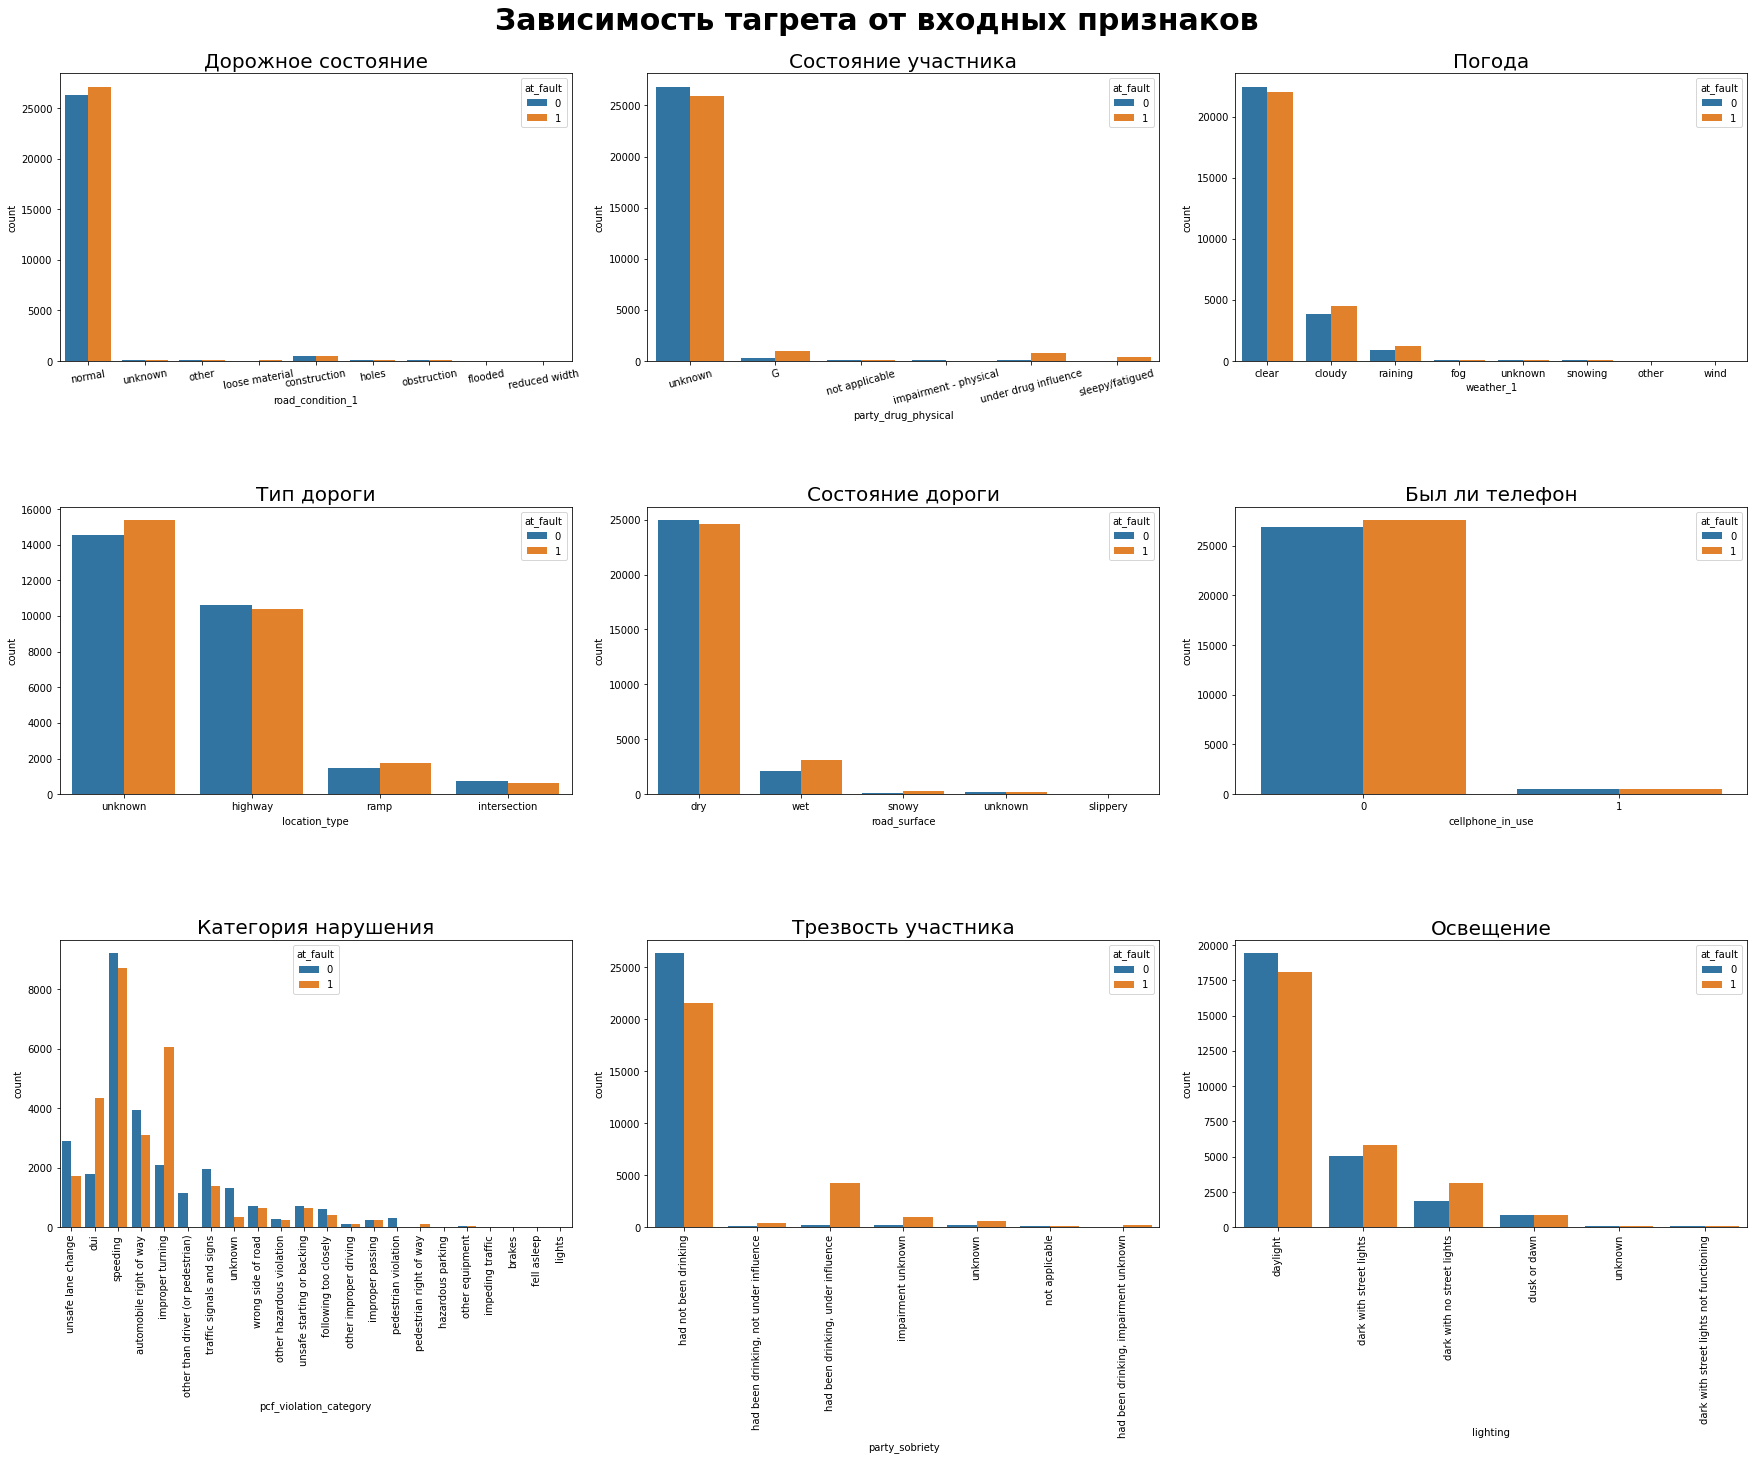

In [66]:
plt.figure(figsize=(25, 30))

plt.suptitle('Зависимость тагрета от входных признаков',
             fontsize=30, fontweight='bold')

plt.subplot(5, 3, 1)
sns.countplot(x='road_condition_1', hue='at_fault', data=selected_df)
plt.xticks(rotation=10)
plt.title('Дорожное состояние', fontsize=20)

plt.subplot(5, 3, 2)
sns.countplot(x='party_drug_physical', hue='at_fault', data=selected_df)
plt.xticks(rotation=15)
plt.title('Состояние участника', fontsize=20)

plt.subplot(5, 3, 3)
sns.countplot(x='weather_1', hue='at_fault', data=selected_df)
plt.title('Погода', fontsize=20)

plt.subplot(5, 3, 4)
sns.countplot(x='location_type', hue='at_fault', data=selected_df)
plt.title('Тип дороги', fontsize=20)

plt.subplot(5, 3, 5)
sns.countplot(x='road_surface', hue='at_fault', data=selected_df)
plt.title('Состояние дороги', fontsize=20)

plt.subplot(5, 3, 6)
sns.countplot(x='cellphone_in_use', hue='at_fault', data=selected_df)
plt.title('Был ли телефон', fontsize=20)

plt.subplot(5, 3, 7)
sns.countplot(x='pcf_violation_category', hue='at_fault', data=selected_df)
plt.xticks(rotation=90)
plt.title('Категория нарушения', fontsize=20)

plt.subplot(5, 3, 8)
sns.countplot(x='party_sobriety', hue='at_fault', data=selected_df)
plt.xticks(rotation=90)
plt.title('Трезвость участника', fontsize=20)

plt.subplot(5, 3, 9)
sns.countplot(x='lighting', hue='at_fault', data=selected_df)
plt.xticks(rotation=90)
plt.title('Освещение', fontsize=20)

plt.tight_layout(pad=3, w_pad=1, h_pad=-8)

По этим графикам можно сказать, что соотношение таргета в целом одинаковое по всем категориям. В некоторых преобладает виновен, в некоторых не виновен. Также можно отметить неожиданный результат, что чаще всего ДТП происходят на сухой дороге и ясной погоде.

Приступим к изучению количественных данны. У нас два таких столбца `county_city_location` и `vehicle_age`

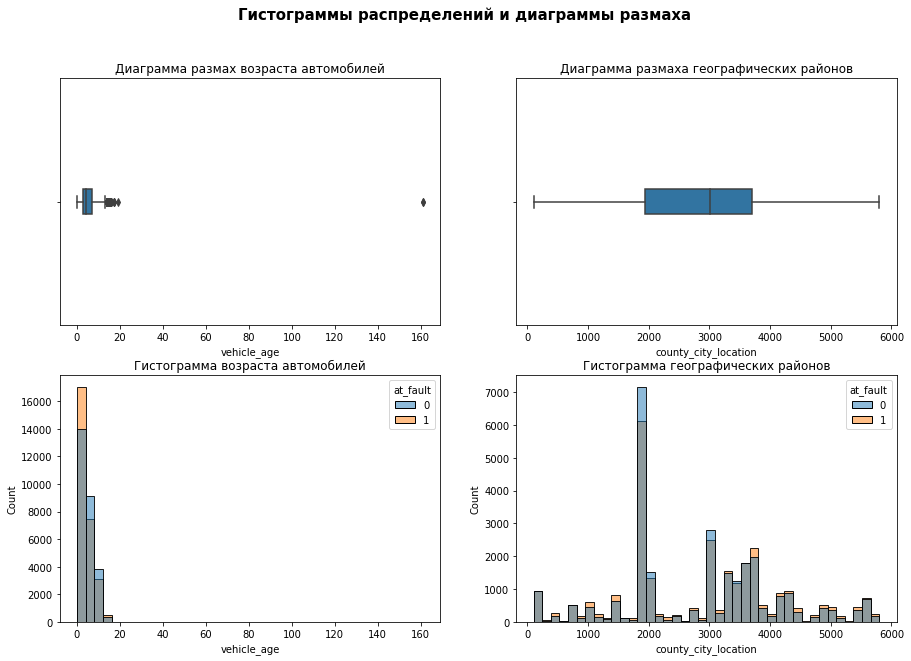

In [67]:
plt.figure(figsize=(15, 10))

plt.suptitle('Гистограммы распределений и диаграммы размаха',
             fontsize=15, fontweight='bold')

plt.subplot(2, 2, 1)
sns.boxplot(x='vehicle_age',  data=selected_df, width=.1)
plt.title('Диаграмма размах возраста автомобилей')

plt.subplot(2, 2, 2)
sns.boxplot(x='county_city_location', data=selected_df, width=.1)
plt.title('Диаграмма размаха географических районов')

plt.subplot(2, 2, 3)
sns.histplot(x='vehicle_age', hue='at_fault', data=selected_df, bins=40)
plt.title('Гистограмма возраста автомобилей')

plt.subplot(2, 2, 4)
sns.histplot(data=selected_df, x='county_city_location',
             bins=40, hue='at_fault')
plt.title('Гистограмма географических районов')

plt.show()

Данные имеют ненормальное распределение, каких-то выбросов незаметно по географическим райнам. В возрасте автомобиля видны аномальные значения, так как у нас каршеринговая компания, то вряд-ли она бы использовала машины старше 12 лет, ну а машина, возраст которой 160 лет, это что-то не то

In [68]:
selected_df[selected_df['vehicle_age'] > 12]  # Смотрим на аномальные значения

,at_fault,party_sobriety,party_drug_physical,cellphone_in_use,weather_1,location_type,road_surface,lighting,county_city_location,pcf_violation_category,collision_time,road_condition_1,vehicle_age
23,0,had not been drinking,unknown,0,clear,highway,dry,dark with street lights,3300,traffic signals and signs,17:50:00,normal,13
137,0,had not been drinking,unknown,0,clear,highway,dry,dark with street lights,1900,speeding,21:35:00,normal,13
321,1,had not been drinking,unknown,0,clear,highway,dry,daylight,5600,improper passing,13:25:00,normal,14
357,1,had not been drinking,unknown,0,cloudy,highway,dry,daylight,3631,speeding,15:21:00,normal,13
361,0,had not been drinking,unknown,0,cloudy,unknown,wet,daylight,4104,unsafe lane change,08:36:00,normal,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55216,1,had not been drinking,unknown,0,clear,unknown,dry,daylight,3012,improper turning,13:10:00,normal,13
55272,1,had not been drinking,unknown,0,clear,unknown,dry,daylight,3000,wrong side of road,10:20:00,normal,14
55276,0,had not been drinking,unknown,0,clear,highway,dry,daylight,1942,speeding,14:55:00,normal,13
55302,1,had not been drinking,unknown,0,clear,unknown,dry,daylight,1920,automobile right of way,14:10:00,normal,14


У нас 879 значения, у которых возраст автомобиля больше 12 лет и 4 значения у которых возраст 161 год. Это явно аномалия, возможно, хотели написать 16 лет и случайно нажали после этого еще на 1. Мы этого не знаем. Удалим как очень аномальные значения (161) так и значения старше 12 лет. 

In [69]:
# Удаляем аномальные значения
selected_df = selected_df[selected_df['vehicle_age'] < 12]

Еще раз построим гистограмму и диаграмму размаха по данному столбцу

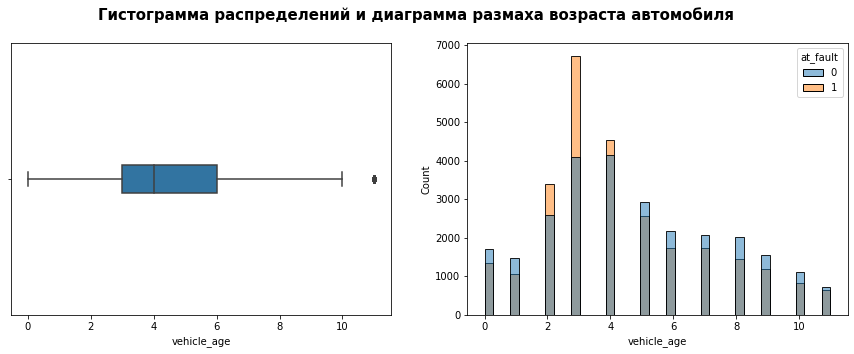

In [70]:
plt.figure(figsize=(15, 5))

plt.suptitle('Гистограмма распределений и диаграмма размаха возраста автомобиля',
             fontsize=15, fontweight='bold')

plt.subplot(1, 2, 1)
sns.boxplot(x='vehicle_age', data=selected_df, width=.1)

plt.subplot(1, 2, 2)
sns.histplot(x='vehicle_age', hue='at_fault', data=selected_df, bins=40)

plt.show()

Аномальных значений нет.

Чтобы убедится, что наши данные имеют ненормальное распределение, проведем статистический тест на нормальность и воспользуемся тестом Шапиро-Уилка, а также построим график QQ-plot. Для этого написали функцию `test_shapiro`

Перед тестом необходимо сформулировать гипотезы:
- **H0** - данные получены из нормального распределения
- **H1** - данные получены из ненормального распределения

Предположим, что верна **H0**, тогда

Отвергаем H0 и принимаем H1.Данные получены из ненормального распределения


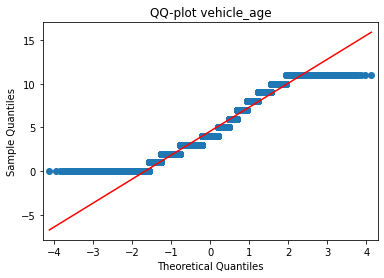

In [71]:
test_shapiro(selected_df['vehicle_age'], ALPHA)

Отвергаем H0 и принимаем H1.Данные получены из ненормального распределения


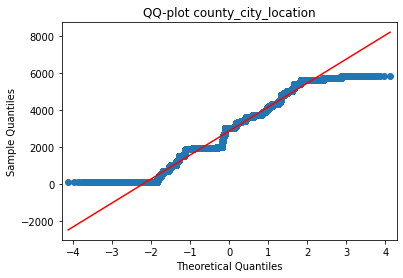

In [72]:
test_shapiro(selected_df['county_city_location'], ALPHA)

Как и ожидалось данные у нас имеют ненормальное распределение

Теперь создадим панельные данные по `at_fault` и времени. И посмотрим есть ли какая-то закономерность между временем происшествия и виновностью участника

In [73]:
pdata_time = selected_df.groupby(['at_fault', 'collision_time'])[
    'at_fault'].count()

# Сделаем таблицу
pdata_time = pd.DataFrame(pdata_time)

# Сделаем данные по at_fault отдельными столбцами
pdata_time_unstacked = pdata_time.at_fault.unstack(level=0)

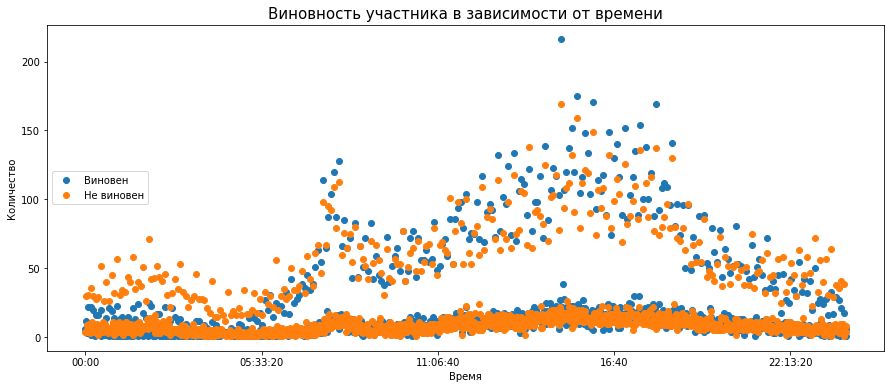

In [74]:
plt.figure(figsize=(15, 6))

pdata_time_unstacked[0].plot(marker='o', label='Виновен', linestyle='None')
pdata_time_unstacked[1].plot(marker='o', label='Не виновен', linestyle='None')
plt.xlabel('Время')
plt.ylabel('Количество')
plt.title('Виновность участника в зависимости от времени', fontsize=15)
plt.legend(loc='center left')

plt.show()

В любое время участник может быть как виновен, так и не виновен.

Категоризируем столбец с временем на следующие категории:

- Ночь с 22:00 до 4:59
- Утро с 5:00 до 11:59
- День с 12:00 до 16:59
- Вечерь с 17:00 до 21:59

In [75]:
# Задаем начало времени суток
night = datetime.time(22, 0, 0)
morning = datetime.time(5, 0, 0)
day = datetime.time(12, 0, 0)
evening = datetime.time(17, 0, 0)

In [76]:
# Создаем новый столбец и заполняем его по условию в зависимости от времени
selected_df.loc[(selected_df['collision_time'] >= night)
                & (selected_df['collision_time'] < morning), 'times_day'] = 'night'

selected_df.loc[(selected_df['collision_time'] >= morning)
                & (selected_df['collision_time'] < day), 'times_day'] = 'morning'

selected_df.loc[(selected_df['collision_time'] >= day)
                & (selected_df['collision_time'] < evening), 'times_day'] = 'day'

selected_df.loc[(selected_df['collision_time'] >= evening)
                & (selected_df['collision_time'] < night), 'times_day'] = 'evening'

In [77]:
# Удалим столбец collision_time, чтобы избежать мультиколлинеарности
selected_df = selected_df.drop(columns=['collision_time'], axis=1)

**Вывод**

Провели исследование наших признаков. В результате выяснили, что соотношение таргета в целом одинаковое по всем категориям. В некоторых преобладает виновен, в некоторых не виновен. В данных были найдены аномальные значения (возраст автомобиля 161 год) их пришлось удалить, кроме того удалили значения, у которых возраст автомобиля больше 12 лет, так как компания не будет использовать для каршеринга на столько старые автомобили. Также выяснили, как визуально, так и при помощи статистического теста распределение наших данных. По итогу все количественные признаки распределены ненормально. Провели исследование таргета в зависимости от времени ДТП. Виновность участника ДТП не зависит от времени самого ДТП.

На основе столбца `collision_time` создали категориальный столбец `times_day`.

Также можно предварительно составить портрет участника и ситуацию.

- Должная ясная погода и сухая дорога
- Движение должно начаться днем
- Путь должен пролежать по шоссе
- Участник обычно трезвый, но использует телефон в машине
- Скорее всего его нарушение будет связано с превышением скорости

#### Корреляционный анализ

Так как наши данные распределены ненормально и большинство из них является категориальными, поэтому, чтобы изучить взаимосвязи между ними, воспользуемся коэффициентом корреляции $\phi_k$ из библиотеки `phik`.

In [78]:
# Расчитываем коэффициент корреляции Фи
phik_matrix = selected_df.phik_matrix(
    interval_cols=['vehicle_age', 'county_city_location'])

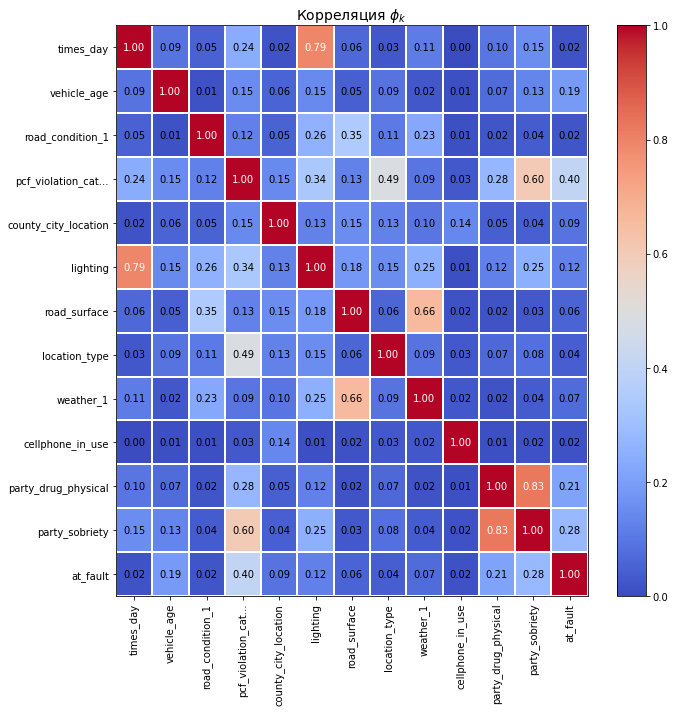

In [79]:
plot_correlation_matrix(phik_matrix.values, x_labels=phik_matrix.columns, y_labels=phik_matrix.index,
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1,
                        figsize=(10, 10))
plt.tight_layout()

Таргет не имеет сильной взаимосвязи с каким-либо признаком. Есть только слабая взаимосвязь с тремя признаками `party_sobriety` - 0.28, `party_drug_physical` - 0.21, `pcf_violation_category` - 0.40.

Между признаками `party_drug_physical` и `party_sobriety` есть сильная взаимосвязь - 0.83 и между `times_day` и `lightin` - 0.79 ожидал, что она будет сильнее. 

Между `road_surface` и `weather_1` - 0.66 также думал, что здесь будет она сильнее. Между `pcf_violation_category` и `party_sobriety` - 0.6, `pcf_violation_category` и `location_type` - 0.49

Остальные признаки либо слабо, либо вообще не коррелируют между собой. 

Признак `cellphone_in_use` неожиданно выглядит бесполезным, пока его оставим, но если что он первый на удаление.

Теперь подготовим обучающую и тестовую выборки. Кодирование и масштабирование данных будет происходить в пайплайне.

In [80]:
# Отделяем таргет
X = selected_df.drop(columns=['at_fault'], axis=1)
y = selected_df['at_fault']

In [81]:
# Разделим данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

Проверим корректно ли все разделилось

In [82]:
X_train.shape, y_train.shape

((40307, 12), (40307,))

In [83]:
X_test.shape, y_test.shape

((13436, 12), (13436,))

## Обучение моделей

Можем приступать к обучению моделей. Целевой признак - `at_fault`. Категориальные данные будет кодировать техникой `OneHotEncoder`, количественные данные будем масштабировать при помощи `StandardScaler`. Перед нами задача бинарной классификации, обучать будем 3 модели:
- `LogisticRegression` 
- `RandomForestClassifier`
- `LGBMClassifier`

При помощи `RandomizedSearchCV` будем подбирать гиперпараметы. Преобразование данных будет происходить в пайплайне. Сравнивать модели будем по метрике `ROC-AUC`, которая сможет показать, какая модель лучше всего классфицирует данные. Далее сравним модели с дамми моделью, чтобы понять, что мы не зря обучали модели. После того как выберем лучшую модель необходимо проверить метрику `precision` - так как совершить ошибку первого рода в данном случае хуже, чем второго. Так как если модель, говорит, что ДТП будет, а его на самом деле не будет, то это лучше (так как никто не пострадает). Чем если модель будет говорить, что ДТП не будет, а оно на самом деле может произойти. Поэтому надо добиться, чтобы модель совершала как можно меньше ошибок первого рода.

In [84]:
# Создаём списки с названиями признаков
ohe_columns = X.select_dtypes(['object', 'int8']).columns.to_list()
num_columns = ['vehicle_age', 'county_city_location']

In [85]:
# Cоздаём пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline([('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))]
                    )

In [86]:
# Cоздаём пайплайн для подготовки признаков из списка num_columns
num_pipe = Pipeline([('SimpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                    ('num', StandardScaler())])

In [87]:
# Создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', num_pipe, num_columns)],
    remainder='passthrough')

In [88]:
# Пайплайн data_preprocessor применям к тренировочной, тестовой выборкам.
X_train_p = data_preprocessor.fit_transform(X_train)
X_test_p = data_preprocessor.transform(X_test)

### LogisticRegression

Первая модель, которую будем обучать это логистическая регрессия. Бдуем подибрать следующие гиперпараметры:
- `C`
- `penalty`
- `solver`

In [89]:
# Инициализируем модель LogisticRegression
model_lg = LogisticRegression(random_state=RANDOM_STATE)

In [90]:
# Параметры для перебора
param_grid = {
    'C': range(1, 10),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']}

In [91]:
# Инициализируем класс для случайного поиска
randomized_search_lg = RandomizedSearchCV(
    model_lg,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [92]:
# Обучаем модель
randomized_search_lg.fit(X_train_p, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
                   n_jobs=-1,
                   param_distributions={'C': range(1, 10),
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'saga']},
                   random_state=42, scoring='roc_auc')

In [93]:
# Делаем предсказания на тесте
y_test_pred_lg = randomized_search_lg.best_estimator_.predict_proba(X_test_p)

In [94]:
print('Лучшая модель и её параметры:\n\n',
      randomized_search_lg.best_estimator_)

print(f'Метрика ROC-AUC на кросс-валидации: \
{randomized_search_lg.best_score_:.2f}')

print(f'Отклонение метрики на кросс-валидации: \
{pd.DataFrame(randomized_search_lg.cv_results_)["std_test_score"].mean():.2f}')

print(f'Cреднее время, затраченное на предсказание: \
{pd.DataFrame(randomized_search_lg.cv_results_)["mean_score_time"].mean():.2f}')

print(
    f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_lg[:,1]):.2f}')

Лучшая модель и её параметры:

 LogisticRegression(C=8, random_state=42, solver='saga')
Метрика ROC-AUC на кросс-валидации: 0.75
Отклонение метрики на кросс-валидации: 0.01
Cреднее время, затраченное на предсказание: 0.01
Метрика ROC-AUC на тестовой выборке: 0.74


### RandomForestClassifier

Вторую модель, которую будем обучать - это `RandomForestClassifier` с параметром `ccp_alpha`=3. Подбирать у нее будем один гиперпараметр:
- `n_estimators`
- `max_depth`
- `min_samples_split`
- `criterion`

In [95]:
# Инициализируем модель RandomForestClassifier
model_rfc = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

In [96]:
# Параметры для перебора
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': range(5, 15),
    'min_samples_split': range(2, 10),
    'criterion': ['gini', 'entropy']
}

In [97]:
# Инициализируем класс для случайного поиска
randomized_search_rfc = RandomizedSearchCV(
    model_rfc,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [98]:
# Обучаем модель
randomized_search_rfc.fit(X_train_p, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(5, 15),
                                        'min_samples_split': range(2, 10),
                                        'n_estimators': [100, 500, 1000]},
                   random_state=42, scoring='roc_auc')

In [99]:
# Делаем предсказания на тесте
y_test_pred_rfc = randomized_search_rfc.best_estimator_.predict_proba(X_test_p)

In [100]:
print('Лучшая модель и её параметры:\n\n',
      randomized_search_rfc.best_estimator_)

print(f'Метрика ROC-AUC на кросс-валидации: \
{randomized_search_rfc.best_score_:.2f}')

print(f'Отклонение метрики на кросс-валидации: \
{pd.DataFrame(randomized_search_rfc.cv_results_)["std_test_score"].mean():.2f}')

print(f'Cреднее время, затраченное на предсказание: \
{pd.DataFrame(randomized_search_rfc.cv_results_)["mean_score_time"].mean():.2f}')

print(
    f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_rfc[:,1]):.2f}')

Лучшая модель и её параметры:

 RandomForestClassifier(criterion='entropy', max_depth=13, min_samples_split=5,
                       n_estimators=500, n_jobs=-1, random_state=42)
Метрика ROC-AUC на кросс-валидации: 0.76
Отклонение метрики на кросс-валидации: 0.01
Cреднее время, затраченное на предсказание: 0.22
Метрика ROC-AUC на тестовой выборке: 0.76


### LGBMClassifier

Теперь воспользуемся градиентным бустингом `LGBMClassifier` с параметрами `lambda_l1`=3, `objectiv`=binary. Будем подбирать следующие гиперпараметры:
- `num_leaves`
- `max_depth`
- `n_estimators`
- `min_child_samples`

In [170]:
# Инициализируем модель LGBM
model_lgbm = LGBMClassifier(random_state=RANDOM_STATE,
                            n_jobs=-1,
                            lambda_l1=3,
                            objective='binary',
                            verbosity=-1)

In [171]:
# Параметры для перебора
param_grid = {
    'num_leaves': [50, 75, 100, 200, 300, 350, 400],
    'max_depth': range(2, 10),
    'n_estimators': [100, 500, 1000],
    'min_child_samples': [30, 35, 40, 50]}

In [172]:
# Инициализируем класс для случайного поиска
randomized_search_lgbm = RandomizedSearchCV(
    model_lgbm,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [173]:
# Обучаем модель
randomized_search_lgbm.fit(X_train_p, y_train)

[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM]

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(lambda_l1=3, objective='binary',
                                            random_state=42, verbosity=-1),
                   n_jobs=-1,
                   param_distributions={'max_depth': range(2, 10),
                                        'min_child_samples': [30, 35, 40, 50],
                                        'n_estimators': [100, 500, 1000],
                                        'num_leaves': [50, 75, 100, 200, 300,
                                                       350, 400]},
                   random_state=42, scoring='roc_auc')

In [174]:
# Делаем предсказания на тесте
y_test_pred_lgbm = randomized_search_lgbm.best_estimator_.predict_proba(
    X_test_p)

In [175]:
print('Лучшая модель и её параметры:\n\n',
      randomized_search_lgbm.best_estimator_)

print(f'Метрика ROC-AUC на кросс-валидации: \
{randomized_search_lgbm.best_score_:.2f}')

print(f'Отклонение метрики на кросс-валидации: \
{pd.DataFrame(randomized_search_lgbm.cv_results_)["std_test_score"].mean():.2f}')

print(f'Cреднее время, затраченное на предсказание: \
{pd.DataFrame(randomized_search_lgbm.cv_results_)["mean_score_time"].mean():.2f}')

print(
    f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_lgbm[:,1]):.2f}')

Лучшая модель и её параметры:

 LGBMClassifier(lambda_l1=3, max_depth=5, min_child_samples=35, num_leaves=100,
               objective='binary', random_state=42, verbosity=-1)
Метрика ROC-AUC на кросс-валидации: 0.76
Отклонение метрики на кросс-валидации: 0.01
Cреднее время, затраченное на предсказание: 0.24
Метрика ROC-AUC на тестовой выборке: 0.76


### DummyClassifier

Теперь проверим модели на адекватность, для этого обучим дами модель, которая предсказывает константу

In [176]:
model_dc = DummyClassifier(strategy='most_frequent')

model_dc.fit(X_train_p, y_train)

y_test_pred_dc = model_dc.predict_proba(X_test_p)

print(
    f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_dc[:,1]):.2f}')

Метрика ROC-AUC на тестовой выборке: 0.50


Все модели прошли проверку на адекватность

### Вывод

Для того, чтобы сравнить все модели сведем их результаты в таблицу.

| **Модели** |**ROC-AUC на CV** | **Отклонение метрики на CV** |**ROC-AUC на тесте** |  **Время предсказания** | **Проверка на адекватность**|
|:----|:----:|:----:|:----:|:----:|:----:|
| **LogisticRegression** | 0.75 | 0.01 | 0.74 | 0.01 | ✅ |
| **RandomForestClassifier** | 0.76 | 0.01 | 0.76 | 0.22| ✅ |
| **LGBMClassifier** | 0.76 | 0.01 | 0.76 | 0.24 | ✅ |

Результаты моделей RandomForestClassifier и LGBMClassifier одинаковые. Возьмем LGBMClassifier, так как он быстрее.

## Проверим лучшую модель в работе

Выбрали лучшую модель RandomForestClassifier. Теперь проведем анализ матрицы ошибок, а также посчитаем `accuracy`, `recall` и `precision`

Метрика accuracy на тестовой выборке: 0.68
Метрика precision на тестовой выборке: 0.78
Метрика recall на тестовой выборке: 0.51


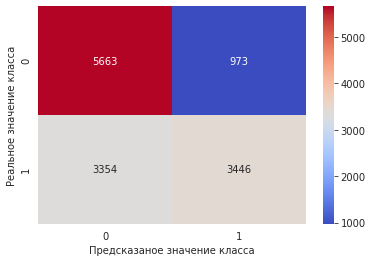

In [169]:
# Считем метрики
y_test_pred = randomized_search_rfc.predict(X_test_p)

print(
    f'Метрика accuracy на тестовой выборке: {accuracy_score(y_test, y_test_pred):.2f}')
print(
    f'Метрика precision на тестовой выборке: {precision_score(y_test, y_test_pred):.2f}')
print(
    f'Метрика recall на тестовой выборке: {recall_score(y_test, y_test_pred):.2f}')

# Строим матрицу ошибок
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.ylabel('Реальное значение класса')
plt.xlabel('Предсказаное значение класса')

Можно сделать предварительные выводы. Мы получили, что доля верных ответов модели равна 68%, наш `precision` равен 78%, recall равняется 51%. Получается, что наша модель чаще избегает ошибки первого рода 73% против 57%.

Для нас важна `precision`. В нашем случае модель ошибочно предсказывает в 973 случаях.

Получается нам необходимо сделать `precision` как можно больше.

Подберем порог, чтобы свести эти ошибки к минимуму. Для этого воспользуемся методом predict_proba и создадим таблицу с отсортированными предсказаниями. Добавим пороги и посмотрим как модель будет работать при 20 разных порогах

In [143]:
data = pd.DataFrame(zip(y_test, y_test_pred_rfc[:, 1]),
                    columns=['y_test', 'y_proba']).sort_values(by='y_proba', ascending=False)

In [144]:
# Разделяем промежуток на более мелкие
thresholds = [round(i, 2) for i in np.linspace(0.1, 1, num=20, endpoint=False)]

In [145]:
# Создаём переменную, которая будет хранить список новых колонок
columns = []

# Добаваляем столбцы с новыми предсказаниями в таблицу
for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_' +
         str(i)] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)

# Выведем 5 случайных строк
print(data.sample(5))

       y_test   y_proba  y_pred_0.1  y_pred_0.15  y_pred_0.19  y_pred_0.24  \
7527        0  0.465132           1            1            1            1   
5755        1  0.422257           1            1            1            1   
5360        1  0.979347           1            1            1            1   
12079       0  0.379470           1            1            1            1   
7083        0  0.722385           1            1            1            1   

       y_pred_0.28  y_pred_0.32  y_pred_0.37  y_pred_0.42  y_pred_0.46  \
7527             1            1            1            1            1   
5755             1            1            1            1            0   
5360             1            1            1            1            1   
12079            1            1            1            0            0   
7083             1            1            1            1            1   

       y_pred_0.5  y_pred_0.55  y_pred_0.6  y_pred_0.64  y_pred_0.68  \
7527          

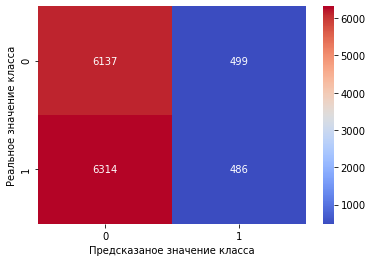

In [146]:
# Строим матрицу ошибок
cm = confusion_matrix(y_test, data['y_pred_0.96'])
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.ylabel('Реальное значение класса')
plt.xlabel('Предсказаное значение класса')

При таком пороге смогли уменьшить в два раза ошибки первого рода, значит наш лучший порог - 0.96.

## Проведите анализ важности факторов ДТП

Посмотрим какие признаки модель считает наиболее важными.

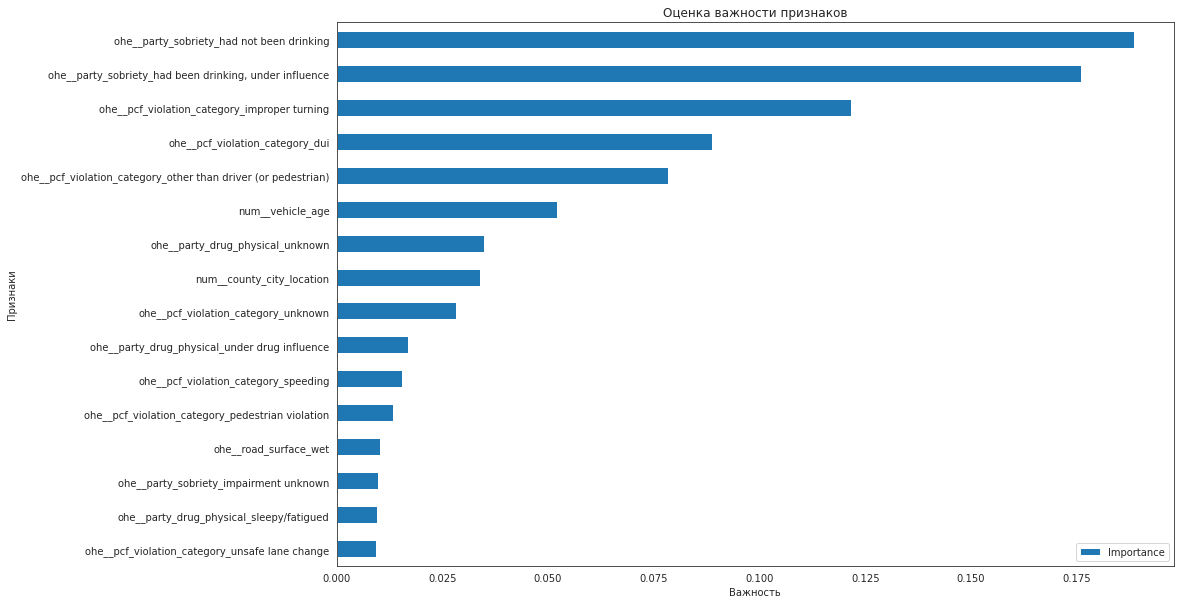

In [147]:
coefficients = randomized_search_rfc.best_estimator_.feature_importances_

sns.set_style('white')
feature_importance = pd.DataFrame(
    {'Feature': data_preprocessor.get_feature_names_out(), 'Importance': np.abs(coefficients)})

feature_importance = feature_importance.sort_values(
    'Importance', ascending=False).reset_index(drop=True)

(
    feature_importance.loc[:15]
    .sort_values(by='Importance', ascending=True)
    .plot(x='Feature', y='Importance', kind='barh', figsize=(15, 10))

)

plt.title('Оценка важности признаков')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.show()

Модель считает наиболее важными признаками такие, как:
- `party_sobriety` - Трезвость участника
- `pcf_violation_category` - Категория нарушения
- `party_drug_physical` - Физическое и наркотическое состояние участника
- `county_city_location`-  Номер географических районов
- `road_surface` - Возраст автомобиля 

Для признака `party_drug_physical` проведем дополнительное исследование. Построим график зависимости фактора и целевой переменной. Так как есть несколько уровней в данной категории то построим столбчатую диаграмму.

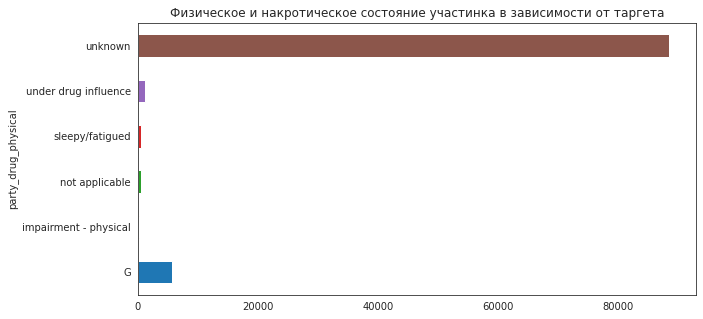

In [180]:
# Строим график
plt.figure(figsize=(10, 5))
selected_df.groupby('party_drug_physical')['at_fault'].count().plot(
    kind='barh', color=mcolors.TABLEAU_COLORS)
plt.title('Физическое и накротическое состояние участинка в зависимости от таргета')

По графику видно, что большая часть ДТП связана с "неизвестным" состоянием участников. Поэтому, чтобы знать, что именно здесь должно быть можно предложить, чтобы автомобиль был оснащен различным оборудованием. То есть, можно поставить камеры, чтобы проверять состояние зрачков участника. Также стоит измерить его сердцебиение, давление и поставить для этого также датчик. Также возможно стоит оснастить машину датчиками звука и заставлять участников проговорить какую-то определенную фразу иногда от разных лекарств может быть побочные действия в виде замедленной речи и т.п. При этом, если пользователь отказывается от таких процедур не допускать его за руль. 

## Вывод

Данные были получены из БД, в которой находилось 3 таблицы:

- collisions
- parties
- vehicles 
- case_ids

Исследование проходило в 8 этапов:

1. Изучение данных
2. Статистический анализ факторов ДТП
3. Подготовка набора данных
4. Обучение моделей
5. Проверка лучшей модели в работе
6. Анализ важности факторов ДТП
7. Общий вывод

**1. Изучение данных**

Первым делом проверили количество таблиц с документацией к БД. Далее проверили все ли таблицы имеют набор данных. В результате получили, что во всех таблицах есть данные, а общий ключ для связи - case_id

- Таблица collisions содержит 1400000 записей.
- Таблица case_ids содержит 1400000 записей.
- Таблица parties содержит 2752408 записей.
- Таблица vehicles содержит 1021234 записей.

**2. Статистический анализ факторов ДТП**

По требованию заказчика нашли в какие месяцы происходит наибольшее количество аварий и сделали вывод. Сначала отобрали за какие года у нас данные по всем месяцам, выяснили, что данные такие есть только за 4 года. Отметили, что после мая в 2012 году, данных о ДТП стало резко меньше. Топ-5 месяцев по авариям следующий:

- Март
- Январь
- Май
- Апрель
- Февраль

Заметили, что топ 5 месяцев — это месяцы первой половины года. Возможно, это связано с погодными условиями и человеческим фактором, так, например, в январе и феврале обычно это самые холодные месяцы и выпадает большое количество снега. Весенние месяцы по той причине, что весной погода очень переменчива, в марте может быть как тепло, так заморозки из-за чего на улицах будет гололедица. То же самое можно сказать и про апрель и даже про май(в некоторой части мира может еще лежать снег). В таких погодных условиях люди чаще ошибаются. 

Также есть еще ряд возможных факторов, такие как:

- Компания может не успевать своевременно менять шины с летней на зимнею и наоборот.
- С наступлением весны, значительно возрастает скорость движения, что ведет к увеличению числа ДТП.
- Весной больше не опытных водителей, которые по-разным причинам отказываются ездить зимой и поэтому возрастает вероятность ДТП с участием не опытных водителей.

Также заказчик потребовал, создать аналитические задачи, чтобы лучше разбираться в данных. По итогу было написано 8 задач и две из них были подробно расписаны и реализованы.

**3. Подготовка набора данных**

Выгрузили набор данных из БД на основе первичного предположения заказчика:

- Тип виновника — только машина (car).
- Случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH.
- Данные только за 2012 год.

Далее провели первичный отбор факторов, необходимых для модели. То есть взяли признаки, которые могут влиять на вероятность ДТП. В результате отобрали 13 признаков, включая таргет и возраст автомобиля (условие заказчика). После этого у нас сформировался датафрейм для дальнейшего изучения. Вывели информацию по датафрейму по итогу у нас получилась таблица размером (56248, 13). 

Выяснили, что в данных есть пропуски и заполнили пропуски в столбце `cellphone_in_use` нулями, так как скорее всего, наличие пропусков связано с тем, что телефона нет. Пропуски в столбце `vehicle_age` заполнили медианным значением, так как предположили, что раз это каршеринговая компания, то она закупает машины оптом, а следовательно, возраст у них должен быть одинаковым. Пропуски в столбце `collision_time` заполнять заглушкой не будем и удалим их. Все остальные пропуски будут заполнены заглушкой `unknown`.

После этого поменяли тип данных в некоторых столбцах (`collision_time`, `county_city_location`, `cellphone_in_use`, `at_fault` и `vehicle_age`).

И в конце сделали проверку на явные и неявные дубликаты. По итогу удалили 662 явных дубликатов, а неявные дубликаты не обнаружили.

Провели исследование наших признаков. В результате выяснили, что соотношение таргета в целом одинаковое по всем категориям. В некоторых преобладает виновен, в некоторых не виновен. В данных были найдены аномальные значения (возраст автомобиля 161 год) их пришлось удалить, кроме того удалили значения, у которых возраст автомобиля больше 12 лет, так как компания не будет использовать для каршеринга на столько старые автомобили. Также выяснили, как визуально, так и при помощи статистического теста распределение наших данных. По итогу все количественные признаки распределены ненормально. Провели исследование таргета в зависимости от времени ДТП. Виновность участника ДТП не зависит от времени самого ДТП.

На основе столбца `collision_time` создали категориальный столбец `times_day`.

Также предварительно составили портрет участника и ситуацию.

- Должная ясная погода и сухая дорога
- Движение должно начаться днем
- Путь должен пролежать по шоссе
- Участник обычно трезвый, но использует телефон в машине
- Скорее всего его нарушение будет связано с превышением скорости

После этого изучили взаимосвязи между данными и для этого воспользовались коэффициентом корреляции $\phi_k$ из библиотеки `phik`. Таргет не имеет сильной взаимосвязи с каким-либо признаком. Мультиколлинеарности между признаками нет.

**4. Обучение моделей**

Обучили 3 модели:
- `LogisticRegression` 
- `RandomForestClassifier`
- `LGBMClassifier`

Целевой признак - `at_fault`. Категориальные данные кодировали техникой `OneHotEncoder`, количественные данные масштабировали при помощи `StandardScaler`. При помощи `RandomizedSearchCV` подобрали гиперпараметы. Для того, чтобы выбрать лучшую модель сравнивали их по метрике `ROC-AUC`, которая сможет показать, какая модель лучше всего классфицирует данные. Также провели сравнение с дамми моделью. Результаты сравнения свели в таблицу:

| **Модели** |**ROC-AUC на CV** | **Отклонение метрики на CV** |**ROC-AUC на тесте** |  **Время предсказания** | **Проверка на адекватность**|
|:----|:----:|:----:|:----:|:----:|:----:|
| **LogisticRegression** | 0.75 | 0.01 | 0.74 | 0.01 | ✅ |
| **RandomForestClassifier** | 0.76 | 0.01 | 0.76 | 0.22| ✅ |
| **LGBMClassifier** | 0.76 | 0.01 | 0.76 | 0.24 | ✅ |

Результаты моделей RandomForestClassifier и LGBMClassifier одинаковые. Возьмем RandomForestClassifier, так как он быстрее.

**5. Проверка лучшей модели в работе**

Для лучшей модели сделали анализ матрицы ошибок, а также посчитали `accuracy`, `recall` и `precision`. Для нас важна метрика `precision` - так как совершить ошибку первого рода в данном случае хуже, чем второго. Так как если модель, говорит, что ДТП будет, а его на самом деле не будет, то это лучше (так как никто не пострадает). Чем если модель будет говорить, что ДТП не будет, а оно на самом деле может произойти. Поэтому надо добиться, чтобы модель совершала как можно меньше ошибок первого рода.

До подбора порога результаты:

- Доля верных ответов модели равна 68% (accuracy)
- precision равен 78%, 
- recall равняется 51%
- Модель ошибочно предсказывает ДТП в 973 случаях.

При пороге 0.96 смогли уменьшить количество ошибок первого рода в два раза. Этот порог и взяли в качестве лучшего.

**6. Анализ важности факторов ДТП**

Модель посчитала наиболее важными признаками такие, как:
- `party_sobriety` - Трезвость участника
- `pcf_violation_category` - Категория нарушения
- `party_drug_physical` - Физическое и наркотическое состояние участника
- `county_city_location`-  Номер географических районов
- `road_surface` - Возраст автомобиля 

Для признака `party_drug_physical` провели более детальное исследование и построили график зависимости от таргета. В результате увидели, что большая часть ДТП связана с "неизвестным" состоянием участников. И предложили, чтобы автомобиль был оснащен различным оборудованием. Например, можно поставить камеры, чтобы проверять состояние зрачков участника. Также стоит измерить его сердцебиение, давление и поставить для этого также датчик. Также возможно стоит оснастить машину датчиками звука и заставлять участников проговорить какую-то определенную фразу иногда от разных лекарств может быть побочные действия в виде замедленной речи и т.п. При этом, если пользователь отказывается от таких процедур не допускать его за руль. 

**Вывод**

Для оценки риска ДТП, лучшей моделью стала `RandomForestClassifier` с гиперпараметрами criterion='entropy', max_depth=13, min_samples_split=5, n_estimators=500. С порогом 0.96 уменьшили в два раза ошибки первого рода. Данная модель считает, что наиболее важные признаки это трезвость, физическое и наркотическое состояние участника. Также отдает предпочтение номеру района, категории нарушения и возрасту автомобиля.

В целом как мне, кажется, создать систему оценки риска при выдаче авто возможно. Но скорее всего она будет ошибаться, так как очень сложно учесть все возможные факторы ДТП. Например, поломку другого автомобиля, которая приведет к ДТП с вашим автомобилем.

Данную модель можно улучшить, но необходимо собрать данные об участнике. То есть знать его возраст, водительский стаж, количество ДТП за все время стажа, а также серьезность этих ДТП (разложить их по различным категориям).